First step: create a regression for each city of the Dataset linking the temperature (celcius)
 and the time (months)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import scipy


In [3]:
data = pd.read_csv('US_City_Temp_Data.csv')
nb_rows, nb_columns = data.shape
T = np.zeros((nb_columns-1, nb_rows))           ## Array where each element is an array with the temperatures of a city over the years
t = np.array(data.iloc[:, 0])                   ## Array with the dates of temperature measurement
cities = np.array(data.columns[1:])             ## Array with the names of the cities
i = 0
for city in cities:
     T[i] = np.array(data[city])
     i += 1



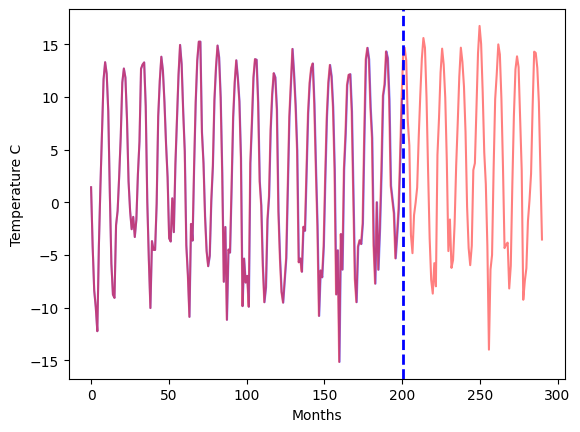

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

months = np.arange(1, 900)                    ## we have 899 dates in the data, each one for a month
nb_of_validation_months = 90                  ## we're doing the predictions on this time frame (so if 12 then we predict the temperatures of next year)
end_work = len(months)-nb_of_validation_months
nb_working_months = 200                       ## both training and testing data separated from validation months

start_work = end_work - nb_working_months     ## not all the datas are useful (1948 is pretty far in the past), also too much data makes it harder to train the model

## create the validation and work (train + test) datasets
working_months = np.linspace(0, nb_working_months, nb_working_months)
months_validation = np.linspace(0, nb_working_months+nb_of_validation_months, nb_working_months+nb_of_validation_months )

city_number = 1;                                  ## We are going to predict the temperature for each city

T_work = T[city_number][start_work:end_work]      ## Temperatures of training and testing
T_validation = T[city_number][start_work:]          ## Temperatures of prediction


plt.plot(working_months, T_work, c='b', alpha=0.5)
plt.plot(months_validation, T_validation, c = 'r', alpha = 0.5)
plt.axvline(months_validation[-nb_of_validation_months], color='blue', linestyle='--', linewidth=2)
# plt.plot(working_months_scaled, T_work_scaled, c = 'b', alpha = 0.5)
# plt.plot(months_validation_scaled, T_validation_scaled, c = 'r', alpha = 0.5)
plt.xlabel('Months')
plt.ylabel('Temperature C')
plt.show()





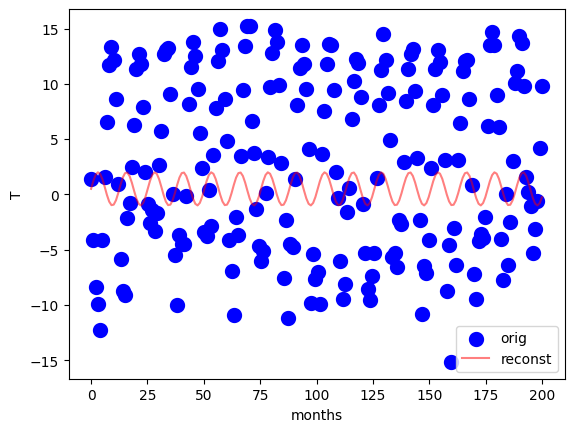

In [29]:
import scipy.linalg as LA

### Technique 1; Non linear regression using gradient descent with different numerical methods

def T_reg(months, beta):
    sinuses = []
    i = 1
    while i <= len(beta)-1:
        sinuses.append(beta[i]*np.sin(beta[i+1]*months))
        i += 2
    reg = beta[0]
    for sinus in sinuses:
        reg += sinus
    return reg

def rrmse(T_city, T_city_pred):
    return (LA.norm(T_city_pred-T_city)) / LA.norm(T_city)

beta0 = np.ones(7,)*0.5
T_pred = T_reg(working_months, beta0)

err = rrmse(T_work, T_pred)

# We can plot the dataset and the original non-linear function
plt.scatter(working_months, T_work, c='b', lw=5, label = 'orig')
plt.plot(working_months, T_pred, c='r', alpha=0.5, label = 'reconst')

plt.legend()
plt.xlabel('months')
plt.ylabel('T')
plt.show()

In [61]:
def error_regression(beta, months, Tcity):
    T_pred = T_reg(months, beta )
    error = rrmse(Tcity, T_pred)
    return error

beta0 = np.ones(7,)*0.505
[beta_opt, beta_all] = scipy.optimize.fmin(error_regression, x0=beta0, args=(working_months,T_work), retall=True, maxfun=10000)


# print(f'')
# print(f'beta_opt = {beta_opt}')
# print(f'error    = {error_regression(beta_opt, working_months, Ti)}')
T_pred = T_reg(months_validation, beta_opt)


Optimization terminated successfully.
         Current function value: 0.283385
         Iterations: 1420
         Function evaluations: 2128


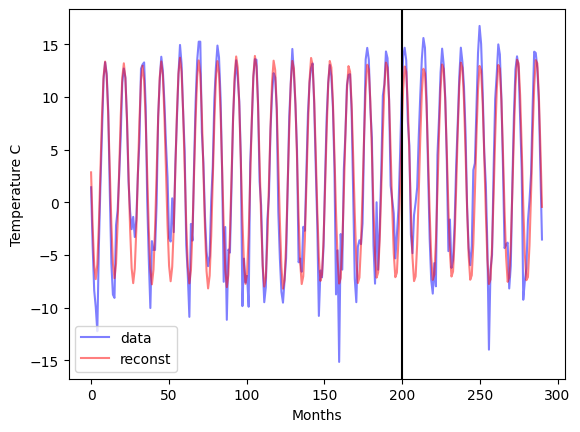

In [64]:
# We can plot the dataset, the original non-linear function and the reconstructed
plt.plot(months_validation, T_validation, c='b', alpha=0.5, label = 'data')
plt.plot(months_validation, T_pred, c='r', alpha=0.5, label = 'reconst')
plt.axvline(nb_working_months, color = 'black')

plt.legend()
plt.xlabel('Months')
plt.ylabel('Temperature C')
plt.show()

Let's split the dataset into test and train and convert them to tensor objects
to use them in pytorch like explained in the exercise session

Let's do the backpropagation now